In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import tqdm
import gc

## Feature enginering

In [2]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [3]:
num_rows = 10000

In [4]:
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(r'C:/Users/houda/Documents/Projet_OC/Projet7/data/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv(r'C:/Users/houda/Documents/Projet_OC/Projet7/data/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [5]:
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(r'C:/Users/houda/Documents/Projet_OC/Projet7/data/bureau.csv', nrows = num_rows)
    bb = pd.read_csv(r'C:/Users/houda/Documents/Projet_OC/Projet7/data/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [6]:
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(r'C:/Users/houda/Documents/Projet_OC/Projet7/data/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [7]:
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(r'C:/Users/houda/Documents/Projet_OC/Projet7/data/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [8]:
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(r'C:/Users/houda/Documents/Projet_OC/Projet7/data/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [9]:
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(r'C:/Users/houda/Documents/Projet_OC/Projet7/data/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [10]:
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(r'C:/Users/houda/Documents/Projet_OC/Projet7/data/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [11]:
df = application_train_test(num_rows)
bureau = bureau_and_balance(num_rows)
df = df.join(bureau, how='left', on='SK_ID_CURR')
prev = previous_applications(num_rows)
df = df.join(prev, how='left', on='SK_ID_CURR')
pos = pos_cash(num_rows)
df = df.join(pos, how='left', on='SK_ID_CURR')
ins = installments_payments(num_rows)
df = df.join(ins, how='left', on='SK_ID_CURR')
cc = credit_card_balance(num_rows)
df = df.join(cc, how='left', on='SK_ID_CURR')

Train samples: 10000, test samples: 10000


C:\Users\houda\AppData\Local\Temp\ipykernel_13032\3411377614.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(test_df).reset_index()


In [191]:
df.drop(columns='index', inplace=True)

In [13]:
df.isin([np.inf, -np.inf]).sum()

index                               0
SK_ID_CURR                          0
TARGET                              0
CODE_GENDER                         0
FLAG_OWN_CAR                        0
                                   ..
CC_NAME_CONTRACT_STATUS_nan_MAX     0
CC_NAME_CONTRACT_STATUS_nan_MEAN    0
CC_NAME_CONTRACT_STATUS_nan_SUM     0
CC_NAME_CONTRACT_STATUS_nan_VAR     0
CC_COUNT                            0
Length: 768, dtype: int64

In [14]:
df.isnull().sum()

index                                   0
SK_ID_CURR                              0
TARGET                              10000
CODE_GENDER                             0
FLAG_OWN_CAR                            0
                                    ...  
CC_NAME_CONTRACT_STATUS_nan_MAX     19257
CC_NAME_CONTRACT_STATUS_nan_MEAN    19257
CC_NAME_CONTRACT_STATUS_nan_SUM     19257
CC_NAME_CONTRACT_STATUS_nan_VAR     19956
CC_COUNT                            19257
Length: 768, dtype: int64

In [15]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

df = df.dropna(axis=1, thresh = int(df.shape[0]*0.2))

In [16]:
df = df.dropna(axis=1, thresh = int(df.shape[0]*0.2))

In [17]:
df.isnull().sum()

index                      0
SK_ID_CURR                 0
TARGET                 10000
CODE_GENDER                0
FLAG_OWN_CAR               0
                       ...  
DAYS_EMPLOYED_PERC      3657
INCOME_CREDIT_PERC         0
INCOME_PER_PERSON          0
ANNUITY_INCOME_PERC       10
PAYMENT_RATE              10
Length: 246, dtype: int64

In [18]:
df.isnull().any()

index                  False
SK_ID_CURR             False
TARGET                  True
CODE_GENDER            False
FLAG_OWN_CAR           False
                       ...  
DAYS_EMPLOYED_PERC      True
INCOME_CREDIT_PERC     False
INCOME_PER_PERSON      False
ANNUITY_INCOME_PERC     True
PAYMENT_RATE            True
Length: 246, dtype: bool

In [19]:
colna = df.columns[df.isnull().any()].tolist()
colna.remove('TARGET')

for elmt1 in colna:
    df[elmt1] = df[elmt1].fillna(df[elmt1].median())

C:\Users\houda\AppData\Local\Temp\ipykernel_13032\4197591950.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[elmt1] = df[elmt1].fillna(df[elmt1].median())


In [21]:
df.isnull().sum()

index                      0
SK_ID_CURR                 0
TARGET                 10000
CODE_GENDER                0
FLAG_OWN_CAR               0
                       ...  
DAYS_EMPLOYED_PERC         0
INCOME_CREDIT_PERC         0
INCOME_PER_PERSON          0
ANNUITY_INCOME_PERC        0
PAYMENT_RATE               0
Length: 246, dtype: int64

In [22]:
df

index  SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0          0      100002     1.0            0             0                0   
1          1      100003     0.0            1             0                1   
2          2      100004     0.0            0             1                0   
3          3      100006     0.0            1             0                0   
4          4      100007     0.0            0             0                0   
...      ...         ...     ...          ...           ...              ...   
19995   9995      172551     NaN            1             0                0   
19996   9996      172556     NaN            0             1                1   
19997   9997      172562     NaN            1             0                0   
19998   9998      172570     NaN            0             0                0   
19999   9999      172574     NaN            1             0                1   

       CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  ...  \
0                 0          202500.0    406597.5      24700.5  ...   
1                 0          270000.0   1293502.5      35698.5  ...   
2                 0           67500.0    135000.0       6750.0  ...   
3                 0          135000.0    312682.5      29686.5  ...   
4                 0          121500.0    513000.0      21865.5  ...   
...             ...               ...         ...          ...  ...   
19995             0          135000.0    454500.0      29173.5  ...   
19996             1          180000.0    500490.0      52555.5  ...   
19997             0          202500.0    523152.0      37336.5  ...   
19998             1          382500.0    967500.0      31338.0  ...   
19999             1          112500.0    539100.0      22837.5  ...   

       WALLSMATERIAL_MODE_Panel  WALLSMATERIAL_MODE_Stone, brick  \
0                             0                                1   
1                             0                                0   
2                             0                                0   
3                             0                                0   
4                             0                                0   
...                         ...                              ...   
19995                         0                                1   
19996                         0                                0   
19997                         1                                0   
19998                         0                                1   
19999                         0                                1   

       WALLSMATERIAL_MODE_Wooden  EMERGENCYSTATE_MODE_No  \
0                              0                       1   
1                              0                       1   
2                              0                       0   
3                              0                       0   
4                              0                       0   
...                          ...                     ...   
19995                          0                       1   
19996                          0                       1   
19997                          0                       1   
19998                          0                       1   
19999                          0                       1   

       EMERGENCYSTATE_MODE_Yes  DAYS_EMPLOYED_PERC  INCOME_CREDIT_PERC  \
0                            0            0.067329            0.498036   
1                            0            0.070862            0.208736   
2                            0            0.011814            0.500000   
3                            0            0.159905            0.431748   
4                            0            0.152418            0.236842   
...                        ...                 ...                 ...   
19995                        0            0.614244            0.297030   
19996                        0            0.141290            0

In [192]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

## modelisation

#### cross validate 
#### MLflow tracking

In [24]:
X = train_df.drop(columns=['TARGET'])
Y = train_df['TARGET']

In [25]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.3)

In [26]:
X_train

index  SK_ID_CURR  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
7390   7390      108614            1             0                0   
2830   2830      103304            1             0                0   
2553   2553      102978            1             0                0   
1047   1047      101216            1             1                0   
369     369      100425            1             1                0   
...     ...         ...          ...           ...              ...   
5328   5328      106231            1             0                0   
5498   5498      106437            1             1                1   
9551   9551      111102            0             1                0   
1313   1313      101542            1             1                1   
7656   7656      108924            1             0                0   

      CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
7390             1          225000.0    896647.5      45909.0   
2830             3           81000.0    242595.0      17383.5   
2553             0          252000.0    358344.0      24075.0   
1047             0          135000.0    518562.0      22099.5   
369              2           90000.0    688500.0      20259.0   
...            ...               ...         ...          ...   
5328             0          180000.0    830214.0      24403.5   
5498             1          391500.0   1006920.0      51543.0   
9551             0          360000.0    835380.0      40320.0   
1313             0          135000.0    900000.0      38263.5   
7656             0          103500.0    770913.0      22540.5   

      AMT_GOODS_PRICE  ...  WALLSMATERIAL_MODE_Panel  \
7390         787500.0  ...                         1   
2830         202500.0  ...                         0   
2553         283500.0  ...                         0   
1047         463500.0  ...                         0   
369          688500.0  ...                         0   
...               ...  ...                       ...   
5328         693000.0  ...                         0   
5498         900000.0  ...                         1   
9551         675000.0  ...                         0   
1313         900000.0  ...                         0   
7656         643500.0  ...                         0   

      WALLSMATERIAL_MODE_Stonebrick  WALLSMATERIAL_MODE_Wooden  \
7390                              0                          0   
2830                              0                          0   
2553                              0                          0   
1047                              0                          1   
369                               0                          1   
...                             ...                        ...   
5328                              0                          0   
5498                              0                          0   
9551                              0                          0   
1313                              0                          0   
7656                              0                          0   

      EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  DAYS_EMPLOYED_PERC  \
7390                       1                        0            0.067799   
2830                       0                        0            0.123750   
2553                       0                        0            0.581794   
1047                       1                        0            0.009408   
369                        1                        0            0.219535   
...                      ...                      ...                 ...   
5328                       1                        0            0.622610   
5498                       1                        0            0.224841   
9551                       0                        0            0.169850   
1313                       0                        0            0.123750   
7656                       0                        0      

In [27]:
y_test

4839    0.0
8696    0.0
8713    0.0
1545    0.0
6579    0.0
       ... 
6218    0.0
3642    0.0
9690    0.0
7711    0.0
1772    0.0
Name: TARGET, Length: 3000, dtype: float64

In [28]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_trainsmote, y_trainsmote = oversample.fit_resample(X_train, y_train)

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from lightgbm import LGBMClassifier

In [30]:
modeles = [LGBMClassifier, DummyClassifier, LogisticRegression,  GradientBoostingClassifier]

In [31]:
dic = dict()
for e in modeles:
    resultats = cross_validate(e(), X_trainsmote, y_trainsmote, cv=5, scoring=['accuracy', 'roc_auc'])
    dic[e.__name__] = [resultats[i].mean() for i in resultats.keys()]
df_scores = pd.DataFrame.from_dict(dic, orient='index', columns=[i for i in resultats.keys()])

[LightGBM] [Info] Number of positive: 5169, number of negative: 5168
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18809
[LightGBM] [Info] Number of data points in the train set: 10337, number of used features: 193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500048 -> initscore=0.000193
[LightGBM] [Info] Start training from score 0.000193
[LightGBM] [Info] Number of positive: 5168, number of negative: 5169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18779
[LightGBM] [Info] Number of data points in the train set: 10337, number of used features: 197
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499952 -> initscore=-0.000193
[Lig

C:\Users\houda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\houda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [32]:
dic

{'LGBMClassifier': [1.0954641342163085,
  0.04373025894165039,
  0.9528029354875412,
  0.9792275068880685],
 'DummyClassifier': [0.021372461318969728,
  0.004139089584350586,
  0.4999226305609284,
  0.5],
 'LogisticRegression': [0.5031014442443847,
  0.03391232490539551,
  0.6234333886257343,
  0.6582320222605926],
 'GradientBoostingClassifier': [28.247903251647948,
  0.03545336723327637,
  0.948469198938865,
  0.9735055477942247]}

In [35]:
#import sklearn
#sklearn.metrics.get_scorer_names()

In [36]:
df_scores

fit_time  score_time  test_accuracy  test_roc_auc
LGBMClassifier               1.095464    0.043730       0.952803      0.979228
DummyClassifier              0.021372    0.004139       0.499923      0.500000
LogisticRegression           0.503101    0.033912       0.623433      0.658232
GradientBoostingClassifier  28.247903    0.035453       0.948469      0.973506

In [37]:
dic_metric = df_scores.to_dict("index")

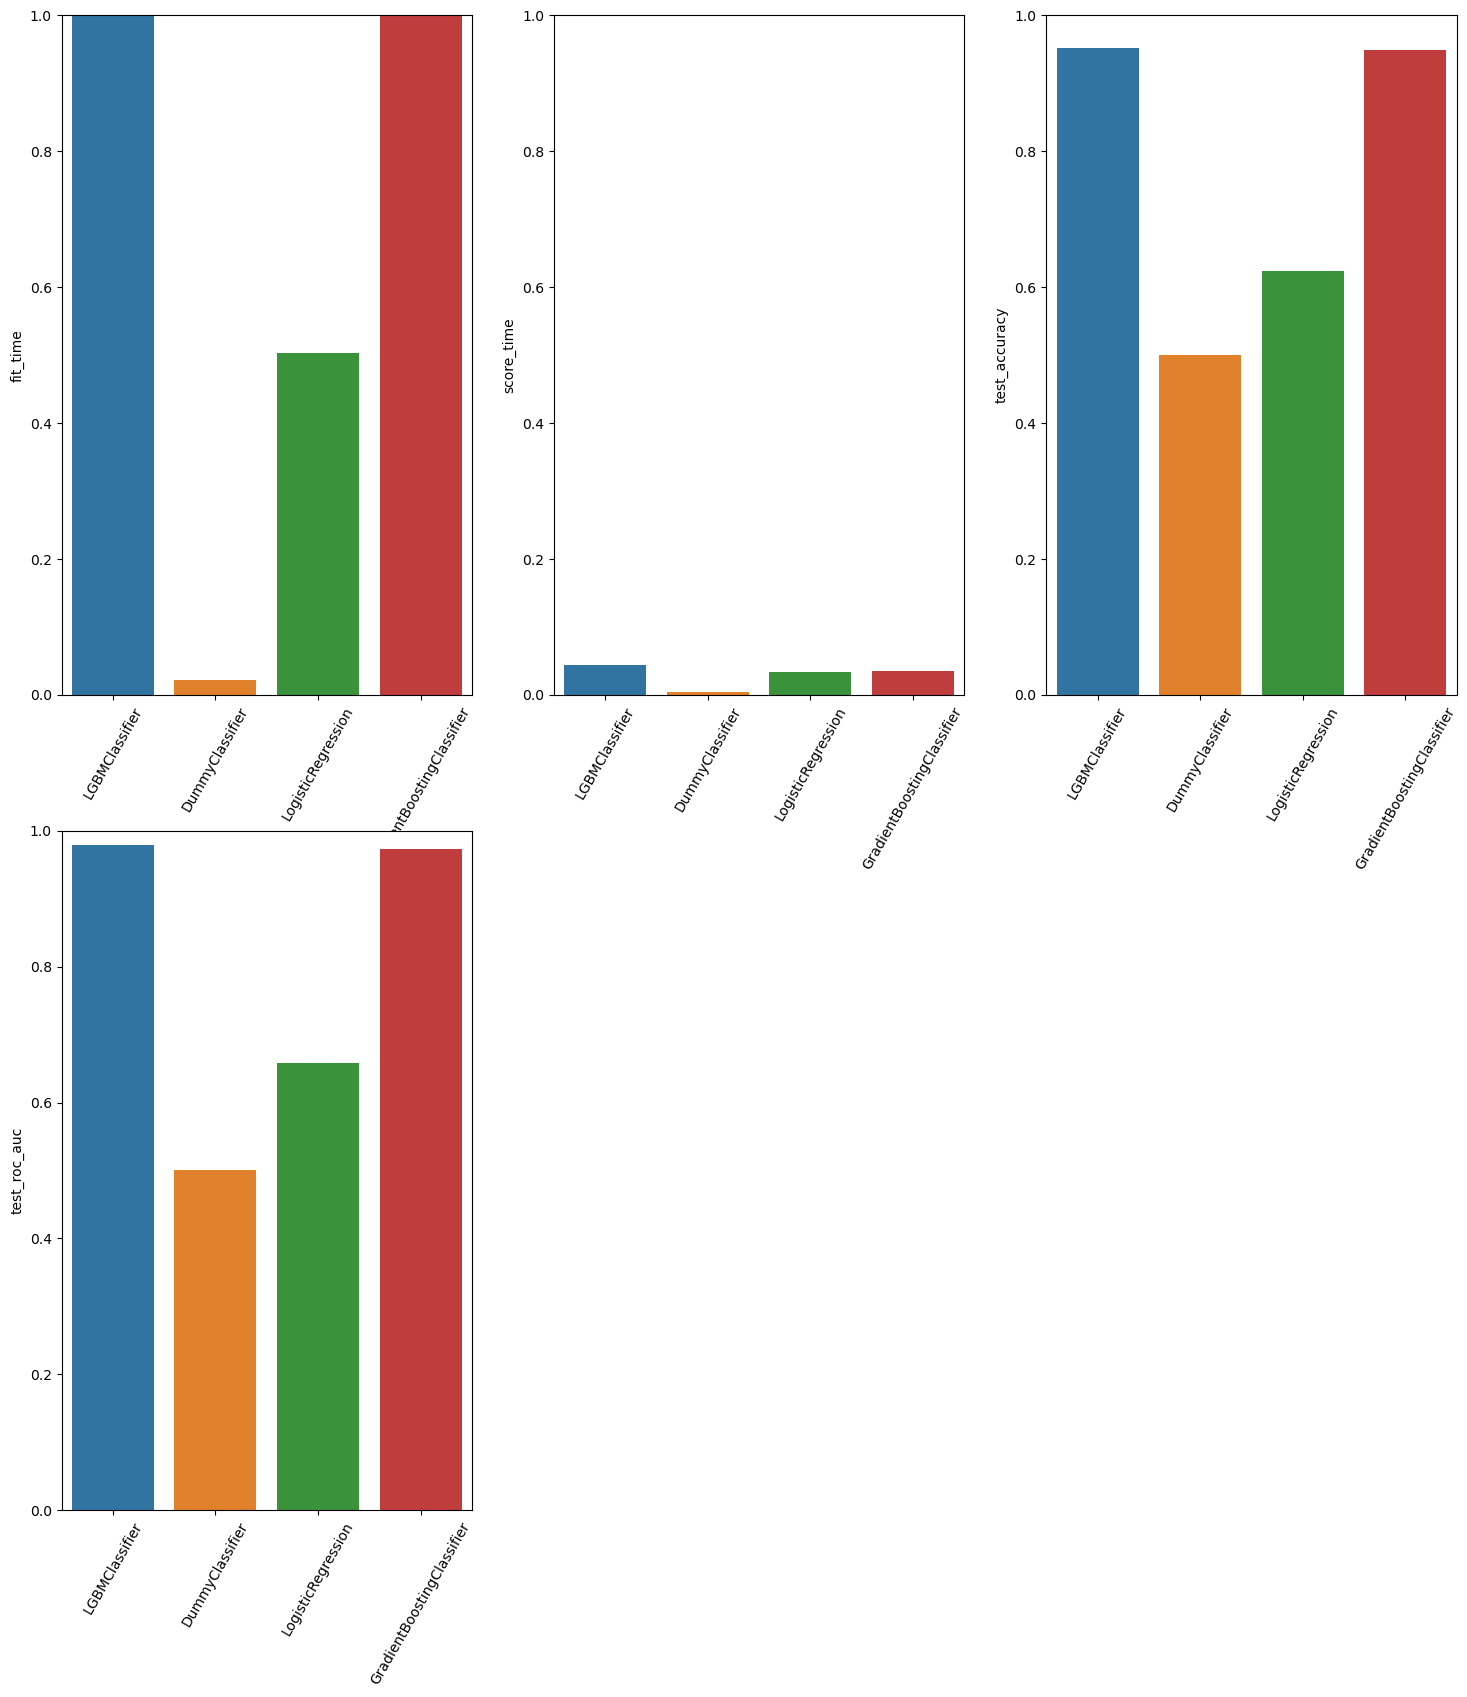

In [38]:
# Graph of the result of the cross validation
plt.figure(figsize=(18,30))
metric = list(resultats.keys())
for i in range(len(metric)):
    plt.subplot(3,3,i+1)
    sns.barplot(x=df_scores.index , y=df_scores[metric[i]])
    plt.xticks(rotation=60)
    plt.ylim((0,1))
plt.savefig('pred.png')
plt.show()

In [133]:
import mlflow

In [134]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("tracking")

mlflow.get_tracking_uri() 

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1700823835317, experiment_id='1', last_update_time=1700823835317, lifecycle_stage='active', name='tracking', tags={}>

In [135]:
mlflow.get_tracking_uri() 

'http://127.0.0.1:5000'

In [210]:
mlflow.sklearn.autolog(disable=True)

with mlflow.start_run(run_name='DummyClassifier'):
    mlflow.set_tag("model_name", "DummyClassifier")
    
    DC = DummyClassifier()
    DC.fit(X_trainsmote, y_trainsmote)
    
    mlflow.log_metrics(dic_metric["DummyClassifier"])
    
    mlflow.sklearn.log_model(DC, "sk_models")

In [69]:
with mlflow.start_run(run_name='LogisticRegression'):
    mlflow.set_tag("model_name", "LogisticRegression")
    
    lr = LogisticRegression()
    lr.fit(X_trainsmote, y_trainsmote)
    
    mlflow.log_metrics(dic_metric["LogisticRegression"])
    
    mlflow.sklearn.log_model(lr, "sk_models")

C:\Users\houda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [72]:
with mlflow.start_run(run_name='GradientBoostingClassifier'):
    mlflow.set_tag("model_name", "GradientBoostingClassifier")
    
    gb = GradientBoostingClassifier()
    gb.fit(X_trainsmote, y_trainsmote)
    
    mlflow.log_metrics(dic_metric["GradientBoostingClassifier"])
    
    mlflow.sklearn.log_model(gb, "sk_models")

In [212]:
with mlflow.start_run(run_name='LGBMClassifier'):
    mlflow.set_tag("model_name", "LGBMClassifier")
    
    lgb = LGBMClassifier()
    lgb.fit(X_trainsmote, y_trainsmote)
    
    mlflow.log_metrics(dic_metric["LGBMClassifier"])
    
    mlflow.sklearn.log_model(lgb, "sk_models")

[LightGBM] [Info] Number of positive: 6480, number of negative: 6480
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18784
[LightGBM] [Info] Number of data points in the train set: 12960, number of used features: 198
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


## Gridshearch avec comme metric auc_roc

In [74]:
from sklearn.model_selection import GridSearchCV

params_lgb = {
    'num_leaves': [31, 200],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 50, 100],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 4, 5]
    }

lgb = LGBMClassifier(random_state=42)

grid_searchlgb = GridSearchCV(estimator = lgb, param_grid = params_lgb, scoring='roc_auc', n_jobs = -1, verbose = 2)

grid_searchlgb.fit(X_trainsmote, y_trainsmote)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 6461, number of negative: 6461
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18818
[LightGBM] [Info] Number of data points in the train set: 12922, number of used features: 179
[LightGBM

GridSearchCV(estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 5],
                         'min_data_in_leaf': [30, 50, 100],
                         'num_leaves': [31, 200], 'reg_alpha': [0.1, 0.5]},
             scoring='roc_auc', verbose=2)

In [78]:
print('The score :', grid_searchlgb.best_score_, 
      '\n the best estimator :', grid_searchlgb.best_estimator_, 
      'with the best parameter :', grid_searchlgb.best_params_)

The score : 0.9791930140060447 
 the best estimator : LGBMClassifier(max_depth=5, min_data_in_leaf=50, random_state=42, reg_alpha=0.1) with the best parameter : {'learning_rate': 0.1, 'max_depth': 5, 'min_data_in_leaf': 50, 'num_leaves': 31, 'reg_alpha': 0.1}


In [80]:
lgb = LGBMClassifier(max_depth=5, min_data_in_leaf=50, random_state=42, reg_alpha=0.1)

lgb.fit(X_trainsmote, y_trainsmote)

y_pred = lgb.predict(X_test)

y_pred_proba = lgb.predict_proba(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 6461, number of negative: 6461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18818
[LightGBM] [Info] Number of data points in the train set: 12922, number of used features: 179
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain

In [81]:
from sklearn.metrics import confusion_matrix

<Axes: >

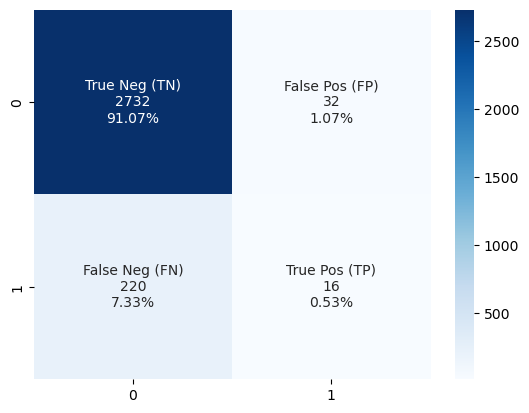

In [135]:
cf_matrix = confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()   
group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']

group_counts = [f"{value :0.0f}" for value in cf_matrix.flatten()]
group_percentages = [f"{value:.2%}" for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    
tpr = float(np.divide(tp,(tp+fn)))
fpr= float(np.divide(fp,(fp+tn)))

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

# Paramètres d'affichage pour l'axe des x.
#plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, labeltop=True)

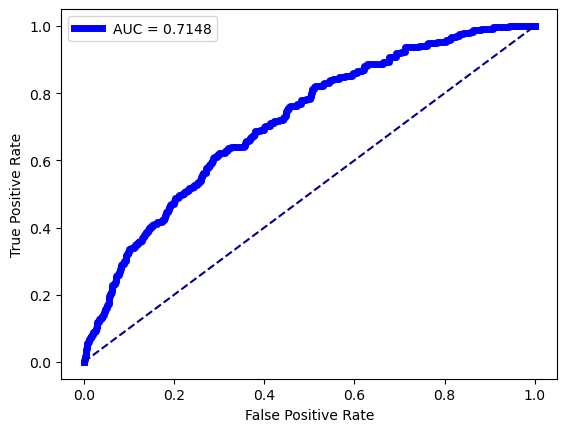

True negative =  2732
False positive =  32
False negative =  220
True positive =  16


In [128]:
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])

plt.plot(fpr, tpr, color='blue', linewidth=5, label='AUC = %0.4f' % roc_auc)

plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

## Gridshearch avec comme metrique metier

In [164]:
from sklearn.metrics import make_scorer

In [153]:
def false_positive_pourcentage(y_test, y_pred):
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()
    
    pfp = fp / np.sum(cf_matrix) *100
    
    return pfp

def false_negative_pourcentage(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()
    
    pfn = fn / np.sum(cf_matrix) *100
    
    return pfn

In [170]:
print(false_positive_pourcentage(y_test, y_pred), false_negative_pourcentage(y_test, y_pred))

1.0666666666666667 7.333333333333333


In [171]:
def business_cost(y_test, y_pred):
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()
    
    pfp = fp / np.sum(cf_matrix) *100
    
    pfn = fn / np.sum(cf_matrix) *100
    
    return 10 * pfp + pfn

In [172]:
business_cost(y_test, y_pred)

18.0

In [173]:
scores = {
    "false_positive_pourcentage" : make_scorer(false_positive_pourcentage, greater_is_better=False),
    "false_negative_pourcentage" : make_scorer(false_negative_pourcentage, greater_is_better=False),
    }

In [174]:
type(false_negative_rate(y_test, y_pred))

numpy.float64

In [175]:
type(scores["false_positive_pourcentage"])

sklearn.metrics._scorer._PredictScorer

In [176]:
grid_searchlgbmetier = GridSearchCV(estimator = lgb, param_grid = params_lgb, scoring=make_scorer(business_cost, greater_is_better=False), n_jobs = -1, verbose = 2)#, refit="false_positive_pourcentage")

grid_searchlgbmetier.fit(X_trainsmote, y_trainsmote)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 6461, number of negative: 6461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18818
[LightGBM] [Info] Number of data points in the train set: 12922, number of used features: 179
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

GridSearchCV(estimator=LGBMClassifier(max_depth=5, min_data_in_leaf=50,
                                      random_state=42, reg_alpha=0.1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 5],
                         'min_data_in_leaf': [30, 50, 100],
                         'num_leaves': [31, 200], 'reg_alpha': [0.1, 0.5]},
             scoring=make_scorer(business_cost, greater_is_better=False),
             verbose=2)

In [178]:
print('The score :', grid_searchlgbmetier.best_score_, 
      '\n the best estimator :', grid_searchlgbmetier.best_estimator_, 
      'with the best parameter :', grid_searchlgbmetier.best_params_)

The score : -8.433333333333332 
 the best estimator : LGBMClassifier(max_depth=5, min_data_in_leaf=50, random_state=42, reg_alpha=0.1) with the best parameter : {'learning_rate': 0.1, 'max_depth': 5, 'min_data_in_leaf': 50, 'num_leaves': 31, 'reg_alpha': 0.1}


Avec comme metric auc_roc:

The score : 0.9791930140060447 
 the best estimator : LGBMClassifier(max_depth=5, min_data_in_leaf=50, random_state=42, reg_alpha=0.1) with the best parameter : {'learning_rate': 0.1, 'max_depth': 5, 'min_data_in_leaf': 50, 'num_leaves': 31, 'reg_alpha': 0.1}
 
 Avec mon metric metier : 
 
 The score : -5.026666666666666 
 the best estimator : LGBMClassifier(max_depth=5, min_data_in_leaf=50, random_state=42, reg_alpha=0.1) with the best parameter : {'learning_rate': 0.1, 'max_depth': 5, 'min_data_in_leaf': 50, 'num_leaves': 31, 'reg_alpha': 0.1}
 
 On a le meme resultat 
 ?????

## Data drift

In [197]:
from evidently import ColumnMapping

reference = train_df.drop(columns=['TARGET'])
current = test_df.drop(columns=['TARGET'])

column_mapping = ColumnMapping()

column_mapping.id = 'SK_ID_CURR'
column_mapping.features = list(current.columns) 

In [196]:
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset
from evidently.metric_preset import TargetDriftPreset

drift_report = Report(metrics=[DataDriftPreset()])
drift_report.run(reference_data=reference, current_data=current, column_mapping=column_mapping)
drift_report

In [200]:
drift_report.save_html("file.html")

In [201]:
json_report = drift_report.json()

In [203]:
dic_report = drift_report.as_dict()

### Pipeline API